In [1]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import wordcloud
from io import StringIO
import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_colwidth', 255)

In [23]:
subjects = []
for media in ['France 3', 'France 2', 'TF1']:
    for year in ['2023']:
        for month in ['1', '2', '3']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [24]:
data = pd.DataFrame(subjects)

In [180]:
focus_media = "france2"
edition = "20h"
weeks_ago = 4

In [181]:
today = datetime.date.today()
weekday = today.weekday()
start_delta = datetime.timedelta(days=weekday, weeks=weeks_ago)

In [182]:
last_week_start = today - start_delta

In [183]:
last_week_end = last_week_start + datetime.timedelta(days=7)

In [184]:
last_week_start, last_week_end

(datetime.date(2023, 1, 30), datetime.date(2023, 2, 6))

In [185]:
last_week = data[(data.media == focus_media)
                 & (data["date"] >= last_week_start.strftime("%Y-%m-%d")) 
                 & (data["date"] < last_week_end.strftime("%Y-%m-%d")) ].copy()

In [186]:
last_week.url

1470                   https://www.francetvinfo.fr/replay-jt/france-2/13-heures/pouvoir-d-achat-quand-les-supermarches-bradent-les-prix-sur-leboncoin_5631083.html
1471                                                      https://www.francetvinfo.fr/sports/sport-et-loisirs/nord-du-ski-dans-l-ancien-bassin-minier_5631131.html
1472    https://www.francetvinfo.fr/replay-jt/france-2/13-heures/dereglement-climatique-les-iles-du-golfe-du-morbihan-menacees-par-la-montee-des-eaux_5631092.html
1473         https://www.francetvinfo.fr/economie/retraite/reforme-des-retraites/reforme-des-retraites-vers-une-plus-forte-mobilisation-le-31-janvier_5630960.html
1474                                      https://www.francetvinfo.fr/replay-jt/france-2/20-heures/autoroutes-une-hausse-record-des-tarifs-des-peages_5631506.html
                                                                                   ...                                                                            
2404                  

In [187]:
import re
if focus_media == 'tf1':
    topic_pattern = re.compile("https://www.tf1info.fr/(\S+)/(\S+).html")
    last_week['topic'] = [topic_pattern.match(u).group(1) for u in last_week.url]
    
if focus_media == 'france2':
    topic_pattern = re.compile("https://www.francetvinfo.fr/(\S+)/(\S+).html")
    last_week['topic'] = [topic_pattern.match(u).group(1).split('/')[0] 
                              for u in [x.replace('https://www.francetvinfo.frhttps://www.francetvinfo.fr', 'https://www.francetvinfo.fr') for x in last_week.url]]

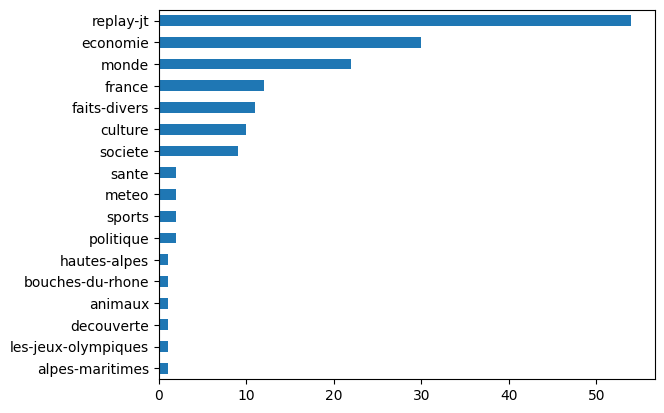

In [188]:
last_week['topic'].value_counts().plot(kind='barh').invert_yaxis()

In [189]:
last_week.columns

Index(['title', 'description', 'date', 'order', 'presenter', 'authors',
       'editor', 'editorDeputy', 'url', 'urlTvNews',
       'containsWordGlobalWarming', 'media', 'topic'],
      dtype='object')

In [190]:
if focus_media == 'france2':
    last_week['formatted_date'] = [d.strftime('%d %B, %A') for d in pd.to_datetime(last_week.date)]  
if focus_media == 'tf1':
    last_week['formatted_date'] = [(d - datetime.timedelta(hours=20)+datetime.timedelta(minutes=1)).strftime('%d %B, %A') for d in pd.to_datetime(last_week.date)]

In [191]:
if focus_media == 'france2' and edition == "20h":
    last_week_edition = last_week[['20h' in x for x in last_week.urlTvNews]].copy()
if focus_media == 'france2' and edition == "13h":
    last_week_edition = last_week[['13h' in x for x in last_week.urlTvNews]].copy()
if focus_media == 'tf1' and edition == "20h":
    last_week_edition = last_week[[('20h' in x) or ('we' in x and d[11:13] >= "20") for x,d in zip(last_week.urlTvNews, last_week.date)]].copy()

In [192]:
if focus_media == 'tf1':
    last_week_edition['id'] = [x.split('-')[-1][:-5] for x in last_week_edition.url]
    last_week_edition['order'] = last_week_edition['date']
    if last_week_edition.formatted_date.nunique() == 1:
        order_by_id = last_week_edition.set_index('id').order.rank(method='first').reset_index().set_index('id').order 
    else:
        order_by_id = last_week_edition.groupby('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_edition['order'] = [order_by_id[x] for x in last_week_edition.id]

In [193]:
if False:
    last_week_edition = last_week[['we' in x for x in last_week.urlTvNews]].copy()
    last_week_edition['id'] = [x.split('-')[-1][:-5] for x in last_week_edition.url]
    last_week_edition['order'] = last_week_20h['id']
    order_by_id = last_week_edition.last_week_edition('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_edition['order'] = [order_by_id[x] for x in last_week_edition.id]

In [194]:
conducteur = last_week_edition.pivot(index='order', columns='formatted_date', values='title')

In [195]:
last_week_edition.formatted_date.value_counts().sort_index()

01 February, Wednesday    12
02 February, Thursday     11
03 February, Friday       12
04 February, Saturday     11
05 February, Sunday        9
30 January, Monday        14
31 January, Tuesday       11
Name: formatted_date, dtype: int64

In [196]:
conducteur

formatted_date,"01 February, Wednesday","02 February, Thursday","03 February, Friday","04 February, Saturday","05 February, Sunday","30 January, Monday","31 January, Tuesday"
order,,,,,,,
1,"VIDEO. ""Nous sommes simplement du bétail"" : un ancien mercenaire du groupe paramilitaire russe Wagner témoigne après avoir déserté le front ukrainien",Mort de Sihem : le suspect est passé aux aveux durant sa garde à vue,États-Unis : un ballon espion chinois crée de nouvelles tensions diplomatiques,Incendie dans les Alpilles : un feu de forêt ravage une centaine d'hectares en plein hiver,"Disparition d'Héléna Cluyou : la piste d'un accident de la route, un suspect identifié par les enquêteurs",Autoroutes : une hausse record des tarifs des péages,Grève du 31 janvier : une mobilisation très forte sur l’ensemble de la France
2,Réforme des retraites : un durcissement de la grève pendant les vacances de février,Mort de Sihem Belouahmia : le profil troublant de son meurtrier présumé,Mort de Sihem Belouahmia : la victime était inquiète avant de rejoindre son meurtrier présumé,Climat : un vent polaire s’abat sur le Canada et les États-Unis,États-Unis : le ballon chinois abattu par l’armée américaine,Grève du 31 janvier contre la réforme des retraites : forte mobilisation attendue dans les transports et dans les écoles,Grève du 31 janvier : les villes moyennes déterminées à poursuivre le mouvement
3,Grève du 31 janvier contre la réforme des retraites : des manifestations importantes dans les villes moyennes,Prêt-à-porter : le secteur de l’habillement de moyenne gamme en crise,Saint-Étienne : un ancien mafieux italien s’est fait passer pour un pizzaiolo,Finistère : une jeune étudiante de 21 ans disparue à Brest depuis une semaine,Géopolitique : une nouvelle guerre froide entre Chinois et Américains ?,Réforme des retraites : des aménagements vont-ils être faits pour les femmes ?,Grève du 31 janvier : de très fortes perturbations dans les transports et les écoles
4,"Inflation : la consommation alimentaire a baissé de 4,6 % en 2022","Réforme des retraites : LR reste ferme sur les annuités, le gouvernement fera-t-il un geste pour les carrières longues ?",Réchauffement climatique : quand la mer grignote le littoral,Disparitions inquiétantes : comment les enquêteurs travaillent-ils ?,Chili : des feux de forêts dévastateurs entraînent la mort d'au moins 23 personnes dans le centre du pays,Disparition de Sihem dans le Gard : la piste de l’enlèvement avec séquestration est explorée,"Réforme des retraites : les syndicats arrêtent deux nouvelles dates de mobilisation, les 7 et 11 février"
5,Immobilier : le bail réel solidaire permet aux ménages modestes d'accéder à la propriété,"Crise énergétique : pour faire baisser la facture, ces commerçants travaillent la nuit","Brésil : les autorités veulent couler le porte-avions Foch, ex fleuron de la marine française","Soupçons de favoritisme : en première ligne de la réforme des retraites, Olivier Dussopt fragilisé","Guerre en Ukraine : la mort des soldats, sujet tabou dans les tranchées",Suicide de Lucas : la mère de l'adolescent témoigne pour la première fois,Consommation : questions sur une nouvelle enseigne à prix bas et circuits courts
6,Disparition de Sihem Belouahmia : la garde à vue du principal suspect a été prolongée,"Énergie : la géothermie, un système économique qui utilise la chaleur sous terre",Guerre en Ukraine : au cœur de la bataille de Vougledar,Santé : les prouesses toujours plus convaincantes de l'immunothérapie face au cancer,"Harcèlement scolaire : Le destin brisé de Juliette, 15 ans",Justice : les laboratoires Urgo condamnés à 6 millions d'amende pour leurs cadeaux aux pharmaciens,Fraude : la saisie de faux billets en France augmente de plus de 8 % en 2022
7,Enquête France 2 : des plaintes refusées par centaines dans les commissariats ou gendarmeries,Commémorations de Stalingrad : Vladimir Poutine utilise l’histoire pour faire le parallèle avec l’invasion en Ukraine,Consommation : ces sites qui

In [197]:
query  = "climat"
last_week_edition[last_week_edition.description.apply(lambda x : query in x.lower())][['date', 'media', 'title', 'url']]

,date,media,title,url
1863,2023-02-01T00:00:00.000Z,france2,Philippines : les rizières en terrasses de Banaue menacées par le changement climatique,https://www.francetvinfo.fr/replay-jt/france-2/20-heures/philippines-les-rizieres-en-terrasses-de-banaue-menacees-par-le-changement-climatique_5634869.html
2140,2023-02-02T00:00:00.000Z,france2,Autriche : une course de patins à glace géante sur un lac glacé,https://www.francetvinfo.fr/monde/europe/autriche-une-course-de-patins-a-glace-geante-sur-un-lac-glace_5636864.html
2387,2023-02-03T00:00:00.000Z,france2,Réchauffement climatique : quand la mer grignote le littoral,https://www.francetvinfo.fr/monde/environnement/rechauffement-climatique-quand-la-mer-grignote-le-littoral_5638901.html


In [198]:
print(last_week_edition[last_week_edition.description.apply(lambda x : query in x.lower())]['description'].iloc[0])

Aux Philippines, les rizières en terrasses de Banaue sont les plus vastes de la planète. Inscrites au patrimoine mondial de l'Unesco, elles sont aujourd'hui menacées par le changement climatique.Au nord des Philippines, les rizières en terrasses de Banaue sont les plus vastes de la planète. Un amphithéâtre de verdure que les Philippins ont surnommé "les escaliers du paradis". En dehors des sentiers battus, deux touristes belges et un Français ont marché pendant près de deux heures à flanc de rizière pour atteindre un point culminant à 1 500 mètres d'altitude. Un site menacé par le changement climatique Inscrites au patrimoine mondial de l'Unesco, ces rizières sont aussi vieilles que certaines pyramides d'Egypte. Façonnées par les fermiers des montagnes pour nourrir les vallées, elles sont encore aujourd'hui cultivées pour leur consommation personnelle. À la différence d'autres plantations de riz ailleurs sur la planète, ces rizières sont inondées toute l'année grâce à un ingénieux syst